In [1]:
%run flow_tools.py

In [2]:
folder = box_dir + 'BadIdea/Flow/20210318 - Low Dose Cell Stim Repeat/'

In [3]:
df = load_data(folder, colnames=["WellName", "Sender", "Receiver",'Ratio','Replicate','Condition'])
df2 = clean_data(df)

In [4]:
df2.loc[df2['Receiver'] == 'LCB1-Notch', 'Receiver'] = 'SARSNotch'

In [72]:
# calculate actual ratio of receivers to sender, not just the predicted ratio.
def get_density(dist, model, k562_component):
    ids = model.predict(dist[:,np.newaxis])
    #k562_ratio = np.sum(ids==k562_component)/np.sum(ids!=k562_component)
    #k562_ratio = np.sum(dist3.5)/np.sum(ids==k562_component)
    k562_ratio = np.sum(ids==k562_component)/len(ids)
    return k562_ratio

sentinel_filter = ((df2.Receiver == 'No Notch') &
                   (df2.Sender == 'None'))
k562_filter = ((df2.Receiver == 'None') &
               (df2.Sender == 'K562'))
joint_dist = df2[sentinel_filter | k562_filter]['logFITC-A'].values[:,np.newaxis]
celltype_model = GaussianMixture(2, covariance_type='spherical',random_state=237).fit(joint_dist)
k562_component, sentinel_component = np.argsort(celltype_model.means_.flat)
df2['Computed Density'] = (df2
                           .groupby(['Sender', 'Receiver','Ratio'])['logFITC-A']
                           .transform(lambda x: get_density(x, celltype_model, k562_component)))
df2.groupby(['Sender','Receiver','Ratio'])['Computed Density'].mean()

Sender      Receiver   Ratio
K562        No Notch   1:1      0.384100
                       2:1      0.268633
                       4:1      0.175943
                       8:1      0.086997
            None       1:1      0.999337
                       2:1      0.998873
                       4:1      0.999461
                       8:1      0.999005
            SARSNotch  1:1      0.266159
                       2:1      0.187666
                       4:1      0.111948
                       8:1      0.057223
None        No Notch   0        0.001435
            SARSNotch  0        0.000000
Spike-K562  No Notch   1:1      0.630354
                       2:1      0.486953
                       4:1      0.339474
                       8:1      0.145844
            None       1:1      0.999869
                       2:1      0.999881
                       4:1      0.999178
                       8:1      1.000000
            SARSNotch  1:1      0.491774
                       2:1  

In [6]:
receivers = ['No Notch', 'SARSNotch']
senders = ['K562', 'Spike-K562']
ratios = ['1:1', '2:1', '4:1', '8:1']
colors = {'No Notch' : '#8C9696', 'SARSNotch' : '#4272B8'}
linestyles = {'K562' : ':', 'Spike-K562': '-'}

In [5]:
filters = ((df2['logFITC-A'] > 4) &
           (df2.Receiver.isin(['No Notch', 'SARSNotch'])))
dist = df2[filters]['logBV 421-A'].values[:,np.newaxis]
model = GaussianMixture(2, covariance_type='spherical', random_state=237).fit(dist)
off_component = np.argmin(model.means_)
summary = (df2[filters].groupby(['Sender','Receiver','Ratio','Replicate'])['logBV 421-A']
              .apply(lambda x: 100*(1-np.sum(model.predict(x.values[:,np.newaxis])==off_component)/len(x)))
              .reset_index())

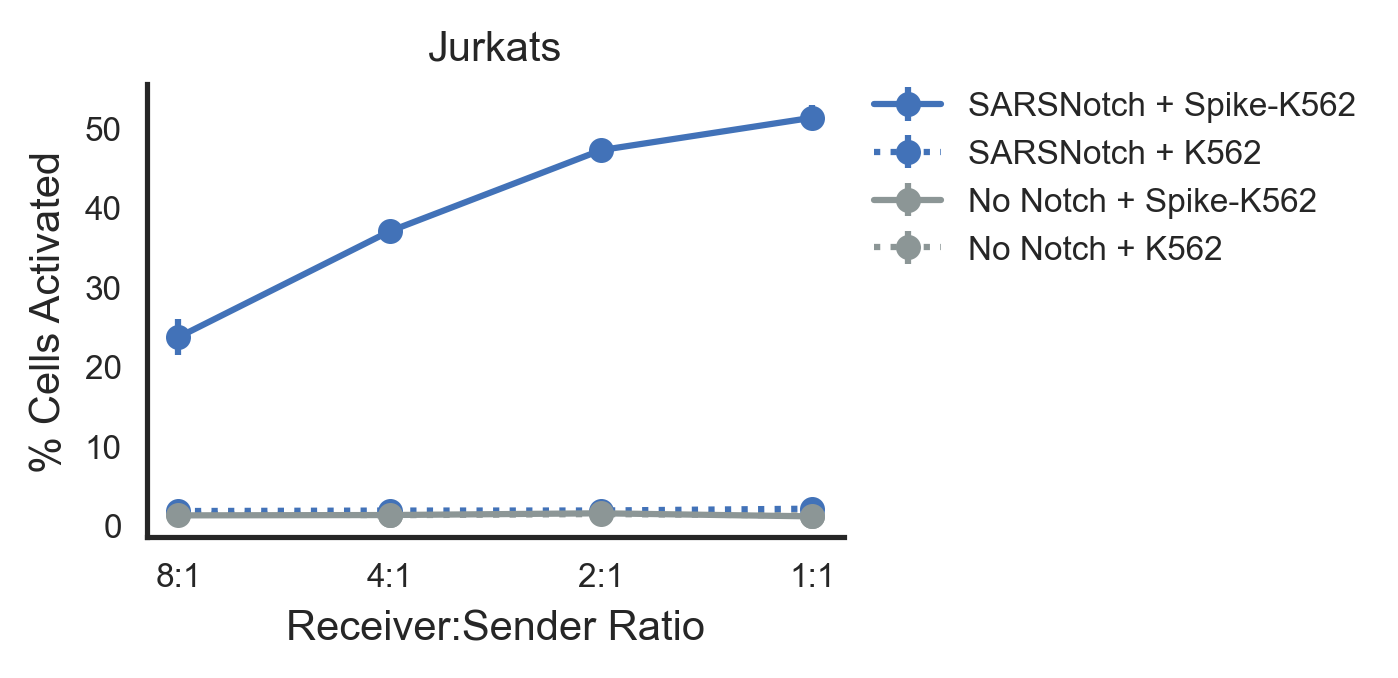

In [7]:
fig, ax = plt.subplots(1,1,figsize=(3,2), dpi=300)
for sender, receiver in product(senders, receivers):
    condition_summary = summary[(summary['Receiver']==receiver) & (summary['Sender']==sender)]
    output = (condition_summary
              .groupby('Ratio')['logBV 421-A']
              .agg([np.mean, np.std])
              .reset_index()
              .sort_values('Ratio', ascending=False))
    ax.errorbar(output['Ratio'], output['mean'], yerr=output['std'], 
                fmt='-', c=colors[receiver], 
                label=f'{receiver} + {sender}',
                marker='.', markersize=10, ls=linestyles[sender])

ax.set_xlabel('Receiver:Sender Ratio')
ax.set_ylabel('% Cells Activated')
plt.legend()
handles, labels = ax.get_legend_handles_labels()
order = [3, 1, 2, 0]
plt.legend([handles[idx] for idx in order],
           [labels[idx] for idx in order],
           frameon=False, loc='upper left', bbox_to_anchor=(1,1.05))
sns.despine()
plt.title('Jurkats')
plt.savefig(outputdir + 'cell_cell_jurkats.svg')

In [73]:
filters = ((df2['logFITC-A'] > 4) &
           (df2.Receiver.isin(['No Notch', 'SARSNotch'])))
dist = df2[filters]['logBV 421-A'].values[:,np.newaxis]
model = GaussianMixture(2, covariance_type='spherical', random_state=237).fit(dist)
off_component = np.argmin(model.means_)
summary = (df2[filters].groupby(['Sender','Receiver','Computed Density','Replicate'])['logBV 421-A']
              .apply(lambda x: 100*(1-np.sum(model.predict(x.values[:,np.newaxis])==off_component)/len(x)))
              .reset_index())

In [71]:
summary.to_csv('low.csv')

/Volumes/Coatamer/Users/weinberz/miniconda3/envs/flow/lib/python3.6/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  from ipykernel import kernelapp as app
/Volumes/Coatamer/Users/weinberz/miniconda3/envs/flow/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


Text(0.5, 1.0, '"Low" Density K562')

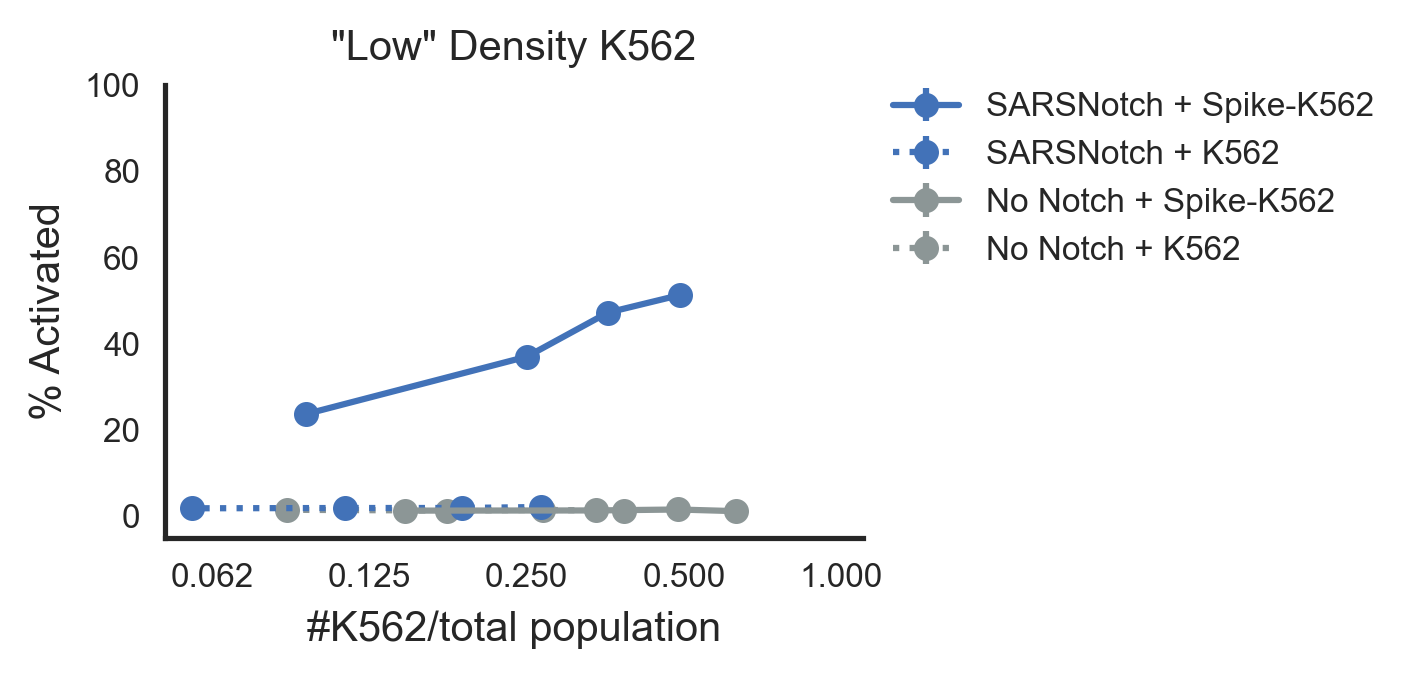

In [75]:
fig, ax = plt.subplots(1,1,figsize=(3,2), dpi=300)
for sender, receiver in product(senders, receivers):
    condition_summary = summary[(summary['Receiver']==receiver) & (summary['Sender']==sender)]
    output = (condition_summary
              .groupby('Computed Density')['logBV 421-A']
              .agg([np.mean, np.std])
              .reset_index()
              .sort_values('Computed Density', ascending=False))
    ax.errorbar(output['Computed Density'], output['mean'], yerr=output['std'], 
                fmt='-', c=colors[receiver], 
                label=f'{receiver} + {sender}',
                marker='.', markersize=10, ls=linestyles[sender])

ax.set_xlabel('#K562/total population')
ax.set_xscale('log', basex=2)
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.legend()
handles, labels = ax.get_legend_handles_labels()
order = [3, 1, 2, 0]
plt.legend([handles[idx] for idx in order],
           [labels[idx] for idx in order],
           frameon=False, loc='upper left', bbox_to_anchor=(1,1.05))
sns.despine()
plt.xlim([-0.1, 1.1])
plt.ylim([-5, 100])
plt.ylabel('% Activated')
plt.title('"Low" Density K562')
#plt.savefig(outputdir + 'cell_cell_jurkats.svg')

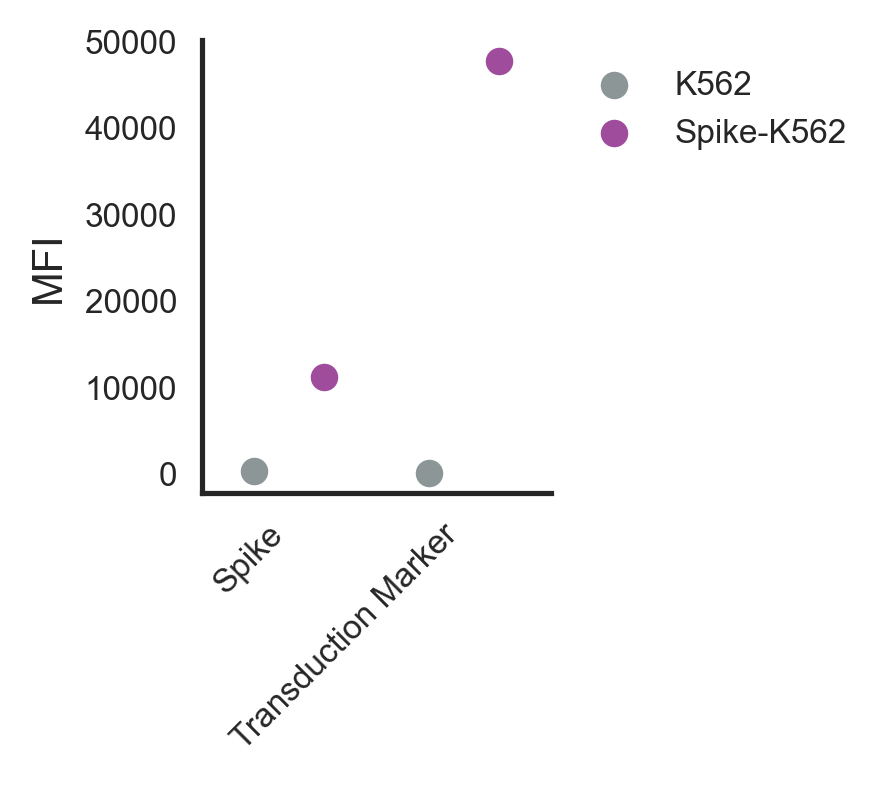

In [9]:
simplified_df = (df2[(df2['Sender'] != 'None') &
                     (df2['Ratio'] != '1:1') &
                     (df2['Receiver'] == 'None')]
                 .reset_index()
                 .melt(value_vars=['PE-CF594-A','APC-A'], 
                       id_vars=['index','Sender','Replicate'],
                       var_name='channel',
                       value_name='counts')
                 .reset_index()
                 .groupby(['Sender','Replicate', 'channel'])['counts']
                 .mean()
                 .reset_index())

simplified_df.loc[simplified_df['channel'] == 'PE-CF594-A', 'channel'] = 'Transduction Marker'
simplified_df.loc[simplified_df['channel'] == 'APC-A', 'channel'] = 'Spike'

with sns.color_palette(['#8C9696', '#A04C9D']):
    fig, ax = plt.subplots(1,1,figsize=(1.5,2),dpi=300)
    g = sns.pointplot(data=simplified_df[(simplified_df['Sender']).isin(['K562', 'Spike-K562'])], 
                      x='channel', y='counts', hue='Sender', join=False, dodge=0.4,
                      hue_order=['K562', 'Spike-K562'], scale=0.75)
    g.legend().remove()
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('')
    plt.ylabel('MFI')
    #plt.ylim([0,500])
    plt.legend(frameon=False,loc='upper left', bbox_to_anchor=[1, 1])
    sns.despine()
    plt.savefig(outputdir + 'mfi_k562.svg')